In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import PCA
from kneed import KneeLocator
import statistics

In [63]:
dataset = pd.read_csv('correct_data.csv')
dataset = dataset[dataset["location"] == "Central"]
dataset["Spend_Pack.Size"] = dataset["Spend"]/dataset["Pack Size"]
dataset["Spend_Volume"] = dataset["Spend"]/dataset["Volume"]

label = pd.read_csv('Category_Label.csv')
dataset = pd.merge(dataset, label, how = "left", on = "Category")

In [46]:
dataset.head()

,Unnamed: 0,Panel ID,Date,Category,Pack Size,Volume,Spend,Calories/100g,Price per Volume,BMI,...,Ethnicity,Lifestage,Strata,#HH,location,Race,SES,Spend_Pack.Size,Spend_Volume,label
0,274473,Panel 201007101,2017-07-09,Sugar,4,4.0,11.8,405,2.94,Healthy,...,Central Malay,Teens Aches,Urban,5 Member HH,Central,Malay,Medium,2.95,2.95,1
1,274474,Panel 201007101,2017-07-09,Flour,1,1.0,2.8,364,2.87,Healthy,...,Central Malay,Teens Aches,Urban,5 Member HH,Central,Malay,Medium,2.80,2.80,2
2,274475,Panel 201007101,2017-07-09,Bouilon,1,0.1,3.6,16,29.09,Healthy,...,Central Malay,Teens Aches,Urban,5 Member HH,Central,Malay,Medium,3.60,36.00,3
3,274476,Panel 201007101,2017-07-09,Bouilon,1,0.1,3.6,16,29.09,Healthy,...,Central Malay,Teens Aches,Urban,5 Member HH,Central,Malay,Medium,3.60,36.00,3
4,274477,Panel 201007101,2017-07-09,Coconut Milk,2,2.0,19.8,233,11.15,Healthy,...,Central Malay,Teens Aches,Urban,5 Member HH,Central,Malay,Medium,9.90,9.90,2


In [64]:
dataset['row_number'] = dataset.groupby(['Panel ID','label']).cumcount()+1
dataset['Mean_Spend_Volume'] = dataset.groupby(['Panel ID','label'])['Spend_Volume'].transform('mean')
dataset['Mean_Spend_Pack.Size'] = dataset.groupby(['Panel ID','label'])['Spend_Pack.Size'].transform('mean')
dataset['Mean_Spend'] = dataset.groupby(['Panel ID','label'])['Spend'].transform('mean')

In [65]:
selected_df = dataset[dataset["row_number"] == 1]
selected_df = selected_df[["Panel ID", "label", "Mean_Spend"]]
selected_df = selected_df.pivot(index='Panel ID',columns='label',values='Mean_Spend')
selected_df = selected_df.fillna(0)

In [66]:
selected_df.corr()

label,1,2,3,4,5,6,7,8
label,,,,,,,,
1,1.000000,0.361752,0.159034,0.160211,0.080667,0.191748,0.273311,0.208771
2,0.361752,1.000000,0.056174,0.130487,0.095870,0.160652,0.158365,0.123776
3,0.159034,0.056174,1.000000,0.171451,0.077453,0.178745,0.262746,0.115926
4,0.160211,0.130487,0.171451,1.000000,0.175575,0.347357,0.385930,0.255757
5,0.080667,0.095870,0.077453,0.175575,1.000000,0.164967,0.232813,0.182098
6,0.191748,0.160652,0.178745,0.347357,0.164967,1.000000,0.455205,0.323394
7,0.273311,0.158365,0.262746,0.385930,0.232813,0.455205,1.000000,0.314473
8,0.208771,0.123776,0.115926,0.255757,0.182098,0.323394,0.314473,1.000000


In [67]:
selected_df.tail()

label,1,2,3,4,5,6,7,8
Panel ID,,,,,,,,
Panel 801891101,6.395789,3.346154,11.300000,3.600000,5.607692,28.00,16.883333,0.000000
Panel 801900701,5.100000,7.733333,13.885714,6.175000,1.400000,18.95,10.000000,2.400000
Panel 801901201,10.154839,3.406383,12.073913,3.609091,5.030435,6.70,7.128571,4.266667
Panel 801903201,40.433333,7.166667,7.360000,5.220000,4.000000,13.00,0.000000,7.860000
Panel 801903801,8.563636,5.185714,4.900000,5.650000,3.400000,16.75,5.000000,6.555556


In [68]:
c = selected_df.corr()
s = c.unstack()
so = s.sort_values(kind="quicksort")
so

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop


def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(selected_df, 50))

Top Absolute Correlations
label  label
6      7        0.455205
4      7        0.385930
1      2        0.361752
4      6        0.347357
6      8        0.323394
7      8        0.314473
1      7        0.273311
3      7        0.262746
4      8        0.255757
5      7        0.232813
1      8        0.208771
       6        0.191748
5      8        0.182098
3      6        0.178745
4      5        0.175575
3      4        0.171451
5      6        0.164967
2      6        0.160652
1      4        0.160211
       3        0.159034
2      7        0.158365
       4        0.130487
       8        0.123776
3      8        0.115926
2      5        0.095870
1      5        0.080667
3      5        0.077453
2      3        0.056174
dtype: float64


In [69]:
location_selected_df = dataset[dataset["row_number"] == 1]
location_selected_df = location_selected_df[["Panel ID", "Race"]]
location_selected_df['row_number'] = location_selected_df.groupby(['Panel ID','Race']).cumcount()+1
location_selected_df = location_selected_df[location_selected_df["row_number"] == 1]

location_selected_df.tail(50)

,Panel ID,Race,row_number
459964,Panel 801742401,Malay,1
459971,Panel 801744201,Chinese,1
460098,Panel 801749501,Malay,1
460125,Panel 801749701,Malay,1
460297,Panel 801767501,Malay,1
460315,Panel 801767701,Malay,1
460327,Panel 801768301,Chinese,1
460541,Panel 801768501,Malay,1
460645,Panel 801768601,Others,1
460777,Panel 801768701,Chinese,1


In [70]:
_ , p_value = calculate_bartlett_sphericity(selected_df)
p_value

4.42793614981114e-235

In [71]:
_, kmo_score = calculate_kmo(selected_df)
kmo_score 

0.771302223060371

In [72]:
fa = FactorAnalyzer(n_factors = 7,  method = 'principal', rotation='varimax',is_corr_matrix=False)
fa.fit(selected_df)
eigenvalues, _ = fa.get_eigenvalues()
variances = fa.get_factor_variance()

Text(0, 0.5, 'Proportion of Variance Explained by PC')

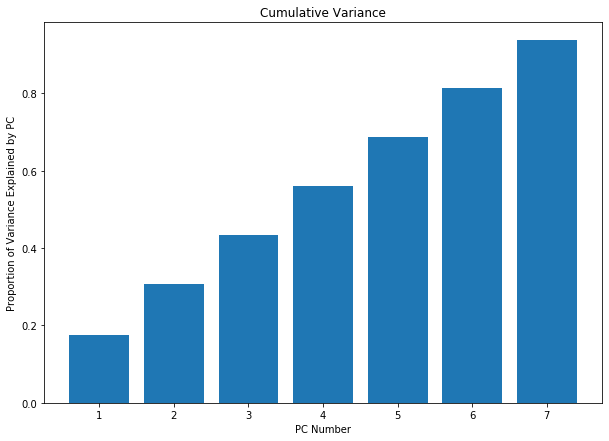

In [73]:
x = list(range(1,8))
plt.figure(figsize=(10, 7)) 
plt.bar(x,variances[2])
plt.title('Cumulative Variance')
plt.xlabel('PC Number')
plt.ylabel('Proportion of Variance Explained by PC')

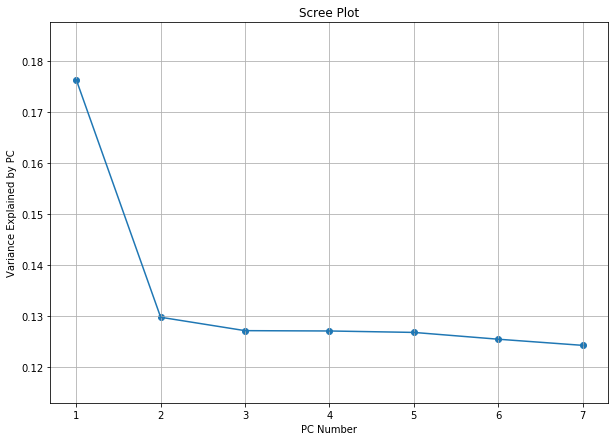

In [74]:
plt.figure(figsize=(10, 7)) 
plt.scatter(range(1,variances[1].shape[0]+1),variances[1])
plt.plot(range(1,variances[1].shape[0]+1),variances[1])
plt.title('Scree Plot')
plt.xlabel('PC Number')
plt.ylabel('Variance Explained by PC')
plt.grid()


# Determine how many principal components to retain.
# The following function does creates a Scree plot for the data.

In [75]:
kl = KneeLocator(range(1, variances[1].shape[0]+1), variances[1], curve="convex", direction="decreasing")

kl.elbow

2

In [36]:
def evaluate_pcs(num_of_pcs,data):
    def encode_vals(x):
        if x <= -0.7 or x >= 0.7:
            return x
        else:
            return("")    
    f = FactorAnalyzer(n_factors=num_of_pcs, method = 'principal',rotation='varimax')
    f.fit(data)
    loadings = pd.DataFrame(f.loadings_).set_index(data.columns)
    loadings = loadings.applymap(encode_vals)
    loadingcols= list(loadings.columns)
    newcols = {}
    for i in loadingcols:
        newcols[i] = "PC" + str(i+1)
    loadings.rename(columns = newcols,inplace=True)
    return loadings

# The following function generates the rotation matrix. Recall that we use
# this matrix to determine if the PCs generated are easily understandable and appropriate.
# The argument "num_of_pcs" specifies, the number of PCs we wish to generate.

def variance_explained(num_of_pcs,data):
    f = FactorAnalyzer(n_factors=num_of_pcs,method='principal', rotation='varimax')
    f.fit(data)
    return f.get_factor_variance()[2][num_of_pcs-1]

# The following function calculates the variance explained by the specified desired number of PCs.

In [76]:
evaluate_pcs(2,selected_df)

# Let us evaluate these results.
# Firstly, notice that there are no negative correlations -- that is good.
# However, PC3 is strongly correlated with only one original variable. There is no linear combinations of features
# We need to either: 
# A) evaluate two PCs, or 
# B) remove this original variable from the data.

,PC1,PC2
label,,
1,,0.789248
2,,0.836219
3,,
4,,
5,,
6,0.702701,
7,0.74581,
8,,


In [77]:
variance_explained(3, selected_df)

0.5756021306818302

In [78]:
new_dataset = selected_df[[1,2,6,7]]

In [79]:
new_dataset.head()

label,1,2,6,7
Panel ID,,,,
Panel 201007101,7.596667,5.617647,12.825000,14.066667
Panel 201009101,7.111268,3.641667,17.966667,7.254348
Panel 201019101,11.436207,22.781818,31.130769,14.885714
Panel 201024101,14.652747,6.444828,30.577778,29.515385
Panel 201047101,8.434884,5.842105,8.437500,11.336364


In [80]:
evaluate_pcs(2,new_dataset)

,PC1,PC2
label,,
1,,0.780061
2,,0.849115
6,0.851055,
7,0.834773,


In [81]:
variance_explained(2, new_dataset)

0.7068770313492345

In [282]:
def CronbachAlpha(itemscores):
    itemscores = np.asarray(itemscores)
    itemvars = itemscores.var(axis=0, ddof=1)
    tscores = itemscores.sum(axis=1)
    nitems = itemscores.shape[1]
    return (nitems / (nitems-1)) * (1 - (itemvars.sum() / tscores.var(ddof=1)))

print(CronbachAlpha(new_dataset[['color','aroma','taste']])) #Reliability of PC1
print(CronbachAlpha(new_dataset[['cost','size','alcohol']])) #Reliability of PC2
print(CronbachAlpha(new_dataset[['cost','size','alcohol','color','aroma','taste']])) #Reliability for all the features
#If we had a diff sample, would we still get these 2PCs with the same features with high loadings


# Now, on to test the reliability of the PCs using Cronbach's alpha, which is a
# measure of the internal consistency of the PCs. The higher their internal
# consistencies, the greater the chance the loadings generated using other
# samples of this data will be similar.

# Both results are greater than our minimum requirement of 0.70. This means the
# PCs generated are reliable.

KeyError: "None of [Index(['color', 'aroma', 'taste'], dtype='object', name='label')] are in the [columns]"

In [82]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(selected_df)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
principalDf["Race"] = list(location_selected_df["Race"])

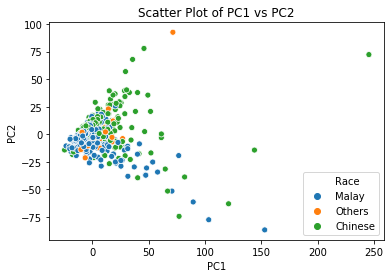

In [83]:
sns.scatterplot(x = "PC1", y = "PC2", hue = "Race", data = principalDf) 
plt.title('Scatter Plot of PC1 vs PC2')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()